# <center> Implementation of  [Lar vonn et. al. ](https://chemistry-europe.onlinelibrary.wiley.com/doi/full/10.1002/cssc.202000867) paper </center>

Model based on <span style="color:red"> formation </span> and <span style="color: red"> diffusion  </span> of neutral lithium atoms transporting electrons through the SEI

Electrone transort <br>
Electron transport from the electrode-SEI interface to the SEI-electrolyte interface can occur through two mechanisms:

1. Electron tunneling in a distance $L_\mathrm{tun}$ into the SEI and reaxt with $Li^0$. For this, the apparent thickness is $L_\mathrm{app} = L_\mathrm{SEI} - L_\mathrm{tun}$.
2. Electrons move with neutral Li atoms ($Li^0$) and are consumed at the SEI-electrolyte interface.
With several additional assumptions (linearizing gradients and averaging the $Li^0$ concentration), they arrive at a simplified expression 

$$J_\mathrm{SEI} = -\frac{c_{\mathrm{Li}} D F}{L_\mathrm{app}} \left (1- \frac{F}{2RT}\frac{L_\mathrm{app}}{k_\mathrm{LI, SEI}^+} J_\mathrm{int} \right)$$


where,
1. $c_{\mathrm{Li}}$ is the concentration of $Li^0$
2. D is the diffusion coefficient of $Li^0$
3. F is Faraday's constant
4. R is the universal gas constant
5. T is temperature
6. $k_{\mathrm{Li, SEI}}^+$ is the lithium ion conductivity
7. $J_{\mathrm{int}}$ is the intercalation current density



"The total current density is divided into two contributions: intercalation and SEI. $J_\mathrm{total} = J_\mathrm{int} + J_\mathrm{SEI}$


$\begin{equation}
   J_\mathrm{total} = J_\mathrm{int} + J_\mathrm{SEI}  \tag{3}
\end{equation}$

$\begin{equation}
    J_\mathrm{int} = 2 j_0 \sinh{ \left ( \frac{F}{2RT} \eta_{\mathrm{int}} \right ) },  \tag{9}
\end{equation}$

$\begin{equation}
    \frac{\text{d}c_s}{\text{d}t} = - \frac{a_n}{F} J_\mathrm{int}  \tag{12}
\end{equation}$

$\begin{equation}
    \frac{\text{d}L_\mathrm{SEI}}{\text{d}t} = - \frac{V_\mathrm{SEI}}{F} J_\mathrm{SEI}  \tag{22}
\end{equation}$


$\begin{equation}
     J_{\mathrm{SEI}}=-j_{\mathrm{SEI}, 0,0} e^{-\alpha_{\mathrm{SEI}} \tilde{\eta}_{\mathrm{SEI}}} \frac{1 \pm \frac{L_{\text {app }}}{L_{\text {mig }}}}{1 \pm \frac{L_{\text {app }}}{L_{\text {mig }}}+\frac{L_{\text {app }}}{L_{\text {diff }}}},  \tag{19}
 \end{equation}$
 

<span style="color:yellow"> We can substitute (9) and (19) into (3), (12), and (22).</span> This results in a Differential Algebraic Equation (DAE) for the variables  $cs, L_\mathrm{SEI}$, and $J_\mathrm{int}$. 

where


$$
    L_{\text {diff }}=\frac{c_{\mathrm{Li}, 0} D F}{j_{\mathrm{SEl}, 0,0}} e^{-\left(1-a_{\mathrm{SE}}\right) \tilde{\eta}_{\mathrm{SEl}}},
$$

$$
    L_{\text {mig }}=\frac{2 R T \kappa_{\mathrm{Li}^{+}, \text {SEI }}}{F\left|J_{\text {int }}\right|},
 $$

$$
    \tilde{\eta}_{\mathrm{SEl}}=\frac{F}{R T}\left(\eta_{\mathrm{int}}+U_{0}+\mu_{\mathrm{Li}, 0} / F\right),
$$

$$
    \eta_\mathrm{int} = \phi_s -  U_0 - \mu_{\mathrm{Li^+, SEI}},
$$

$$
    U_{0}=\left(\frac{1.24-c_{\mathrm{s}} / c_{\mathrm{s}, \max }}{1.16}\right)^{2.92}
$$


$$
    j_{0} = j_{0,0} \sqrt{\frac{c_s}{c_{s, max}}},
$$

In [287]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
# import time
# import scipy.sparse as sparse
# pybamm.__version__

Defining varaibles

In [288]:

cs = pybamm.Variable("concentration [mol.m-3]")
L_SEI = pybamm.Variable("Thickness of SEI [m]")
# Either eta_Int or J_int can be considered as the state variable
# eta_int = pybamm.Variable("Overpotential [V]")
J_int = pybamm.Variable("intercalation current density [A m-2]")
Q = pybamm.Variable("capacity [A.h]")

Define Model Parameters

In [289]:

c_Li = pybamm.Parameter(
    'Lithium atom reference concentration [mol.m-3]')
alpha_SEI = pybamm.Parameter("alpha_SEI [-]")
j_SEI_0_0 = pybamm.Parameter(
    'Initial SEI reaction exchange current density [A.m-2]')
T = pybamm.Parameter('Initial temperature [K]')
R = pybamm.Parameter('Ideal gas constant [J.K-1.mol-1]')
F = pybamm.Parameter("Faraday constant [C.mol-1]")
cs_max = pybamm.Parameter(
    "maximum lithium ion concentration in electrode [mol.m-3]")
v_SEI = pybamm.Parameter("Mean moler volume of SEI [m3.mol-1]")
kappa_Li_SEI = pybamm.Parameter(
    "Lithium ion conductivity of the SEI [S.m-1]")
mu_Li_0 = pybamm.Parameter(
    "Chemical reference potential of Li^0 [J.mol-1]")
L_app_0 = pybamm.Parameter("Reference apparent thickness  [nm]")
L_tun = pybamm.Parameter("typical tunning distance  [nm]")
U1 = pybamm.Parameter("Maximum Voltage during cycling [V]")
U2 = pybamm.Parameter("Minimum Voltage during cycling [V]")
j0_0 = pybamm.Parameter(
    "Butler-Volmer rate constant for intercalation [A.m-2]")
D_Li = pybamm.Parameter(
    "Diffusion coefficient of Li atoms inside the SEI [m2.s-1]")
# J_total = pybamm.Parameter("Current density [A.m-2]")
A_cb = pybamm.Parameter(
    "Surface area to volume ratio [m-1]")
A_cb_m = pybamm.Parameter(
    "Mass specific area of carbon black [m2 g-1]")
L_SEI_0 = pybamm.Parameter("Initial thickness of SEI [m]")
cs_0 = pybamm.Parameter("Initial concentration [mol.m-3]")


def U0(x):
    return pybamm.FunctionParameter(
        "open circuit voltage OCV [V]",
        {"Negative particle stoichiometry": x},
    )


def OCP(sto):
    return pybamm.Power((1.24 - sto)/1.16, 2.92)


def J_total(t):
    return pybamm.FunctionParameter(
        "Current density [A.m-2]", {"time": t})


t_ch = 31000   # [s]
t_rest = 5000  # [s]
t_dch = 1.98*t_ch + t_rest  # [s]
t_end = 2*t_dch
# sum_t = t_ch
# nums_t = [t_ch]
# while sum_t < t_end:
#     sum_t += t_dch
#     nums_t.append(sum_t)


# Qs,nom Nominal maximum capacity of carbon black 200 mA h g−1
#  for example C/10
# Acb,m = 62 m2 g−1
#  Taccording to equation 29 J[Am-2]=Qs,nom*0.001/1h 1/Acb

def currentDensity(t):
    cccv1 = -0.0004  # [A.m-2]
    cccv2 = -cccv1
    tc = pybamm.Modulo(t, t_dch)
    # tc = t
    return (cccv1*pybamm.NotEqualHeaviside(tc, t_ch)
            + cccv2*pybamm.NotEqualHeaviside(t_ch + t_rest, tc)
            * pybamm.NotEqualHeaviside(tc, t_dch))

Parameter values from Lars von Wedel 2020  https://doi.org/10.1016/j.jpowsour.2020.228923 suplementary material.

In [290]:

params = pybamm.ParameterValues(
    {'Lithium atom reference concentration [mol.m-3]': 1,  # Lar
     "alpha_SEI [-]": 0.22,  # Lars
     'Initial SEI reaction exchange current density [A.m-2]': 7.04e-5,  # Lars
     'Initial temperature [K]': 303,  # Lars standard temperature
     'Ideal gas constant [J.K-1.mol-1]': 8.314462618,  # Lar standard
     "Faraday constant [C.mol-1]": 96485,  # Lars standard
     "maximum lithium ion concentration in electrode [mol.m-3]": 11387,  # Lars
     #  "maximum lithium ion concentration in electrode [mol.m-3]": 27760,  # Lars
     "Mean moler volume of SEI [m3.mol-1]": 1.078e-5,  # Lars
     "Lithium ion conductivity of the SEI [S.m-1]": 1e-8,
     # Lars was in KJ
     "Chemical reference potential of Li^0 [J.mol-1]": 17.4e+3,
     "Reference apparent thickness  [nm]": 0.02e-9,  # Lars
     "typical tunning distance  [nm]": 1.52e-9,  # Lars
     "Maximum Voltage during cycling [V]": 1.2,  # Lars
     "Minimum Voltage during cycling [V]": 0.01,    # Lars
     "Butler-Volmer rate constant for intercalation [A.m-2]": 6.4e-3,
     "Diffusion coefficient of Li atoms inside the SEI [m2.s-1]": 1e-15,
     "Surface area to volume ratio [m-1]": 86.8e+6,
     "Initial thickness of SEI [m]": 2.5e-9,
     "open circuit voltage OCV [V]": OCP,
     # (2-40 mA h g-1) /Acb (0.000032 -0.00065)
     "Current density [A.m-2]": currentDensity,
     "Initial concentration [mol.m-3]": 150,
     "Mass specific area of carbon black [m2 g-1]": 62,
     }
)

In [291]:
model = pybamm.lithium_ion.BaseModel()

Defining variables of the model

In [292]:

eta_int = 2*R*T/F * pybamm.arcsinh((J_int) /
                                   (2*j0_0 * pybamm.sqrt(cs/cs_max)))

# J_int = 2*j0_0 * pybamm.sqrt(cs/cs_max) * \
#     pybamm.sinh(F/(2*R*T) * eta_int)
eta_bar_SEI = F/(R*T) * (eta_int + U0(cs/cs_max) + mu_Li_0/F)
L_diff = c_Li * D_Li * F / j_SEI_0_0 * pybamm.exp(-(1-alpha_SEI) * eta_bar_SEI)
L_mig = (2 * R * T * kappa_Li_SEI)/(F*pybamm.AbsoluteValue(J_int))
L_prime_app = L_SEI - L_tun

L_app = (L_prime_app / 2 + pybamm.Power(pybamm.Power(L_prime_app /
         2, 10) + pybamm.Power((L_SEI_0-L_tun), 2), 0.1))*pybamm.EqualHeaviside(L_prime_app, 0) + \
    pybamm.EqualHeaviside(-L_prime_app, 0) * L_prime_app


J_SEI = - j_SEI_0_0 * pybamm.exp(-alpha_SEI * eta_bar_SEI) *\
    (1 - L_app/L_mig * pybamm.sign(J_total(pybamm.t))) / \
    (1 - L_app/L_mig * pybamm.sign(J_total(pybamm.t)) + L_app/L_diff)

model.algebraic = {
    J_int:  J_total(pybamm.t) - (J_int + J_SEI)
}

In [293]:

dcsdt = - A_cb*J_int/F
dL_SEIdt = - v_SEI * J_SEI / F
dQdt = - J_int * A_cb_m

model.rhs = {cs: dcsdt, L_SEI: dL_SEIdt, Q: dQdt}

In [294]:

model.events.append(
    pybamm.Event(
        "discontinuity",
        pybamm.Scalar(31000),
        event_type=pybamm.EventType.DISCONTINUITY))

model.events.append(
    pybamm.Event(
        "discontinuity",
        pybamm.Scalar(36000),
        event_type=pybamm.EventType.DISCONTINUITY))


model.events.append(
    pybamm.Event(
        "discontinuity",
        pybamm.Scalar(66000),
        event_type=pybamm.EventType.DISCONTINUITY))


model.events.append(
    pybamm.Event(
        "discontinuity",
        pybamm.Scalar(97380),
        event_type=pybamm.EventType.DISCONTINUITY))


model.events.append(
    pybamm.Event(
        "discontinuity",
        pybamm.Scalar(98711),
        event_type=pybamm.EventType.DISCONTINUITY))

model.events.append(
    pybamm.Event(
        "discontinuity",
        pybamm.Scalar(102380),
        event_type=pybamm.EventType.DISCONTINUITY))

model.events.append(
    pybamm.Event(
        "discontinuity",
        pybamm.Scalar(132901),
        event_type=pybamm.EventType.DISCONTINUITY))


model.variables = {
    "concentration [mol.m-3]": cs,
    "Thickness of SEI [m]": L_SEI,
    "intercalation current density [A m-2]": J_int,
    "Voltage [V]": U0(cs/cs_max)+eta_int,
    # "Opencircuit voltage [V]": U0(cs/cs_max),
    "L_mig": L_mig,
    "L_diff": L_diff,
    "L_app": L_app,
    "J_SEI": J_SEI,
    "eta_int": eta_int,
    "J_int": J_int,
    "capacity [A.h]": Q/3600/0.001,
    "Q1 [A.h]": pybamm.NotEqualHeaviside(J_int, 0) * Q/3600/0.001,
    "Q2 [A.h]": pybamm.NotEqualHeaviside(-J_int, 0) * Q/3600/0.001,
    # "Ic": -pybamm.NotEqualHeaviside(J_int, 0) * A_cb_m*pybamm.Integral(J_int, pybamm.t)
    # "Capcity": -pybamm.EqualHeaviside(J_total(pybamm.t), 0) * (J_int*A_cb_m*pybamm.t*0.000277778)/(0.001),
    # "Capcity": (J_int*A_cb_m*pybamm.t/U0(cs/cs_max)*0.000277778),

}

In [295]:


model.initial_conditions = {
    cs: cs_0,
    L_SEI: L_SEI_0,
    # eta_int: U0(cs_0/cs_max)
    J_int: J_total(0),
    Q: 0
}

In [296]:
params.process_model(model)
disc = pybamm.Discretisation()  # use the default discretisation
disc.process_model(model)

solver = pybamm.IDAKLUSolver()

# t = np.linspace(0.0, t_end, 100000)
# t = [0, t_cutoff + t_rest]

t = [0, t_end]

sim = pybamm.Simulation(
    model, parameter_values=params, solver=solver)

In [297]:
solution = sim.solve(t_eval=t)

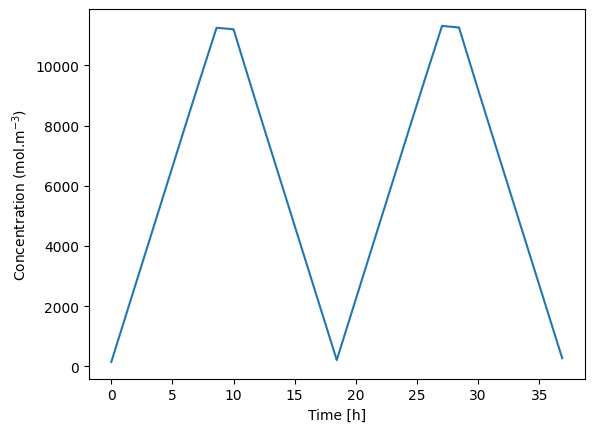

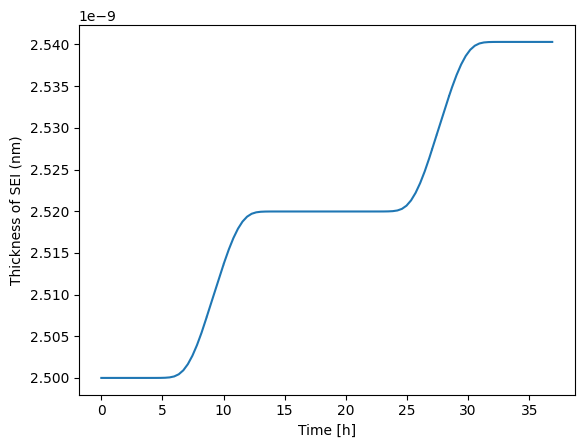

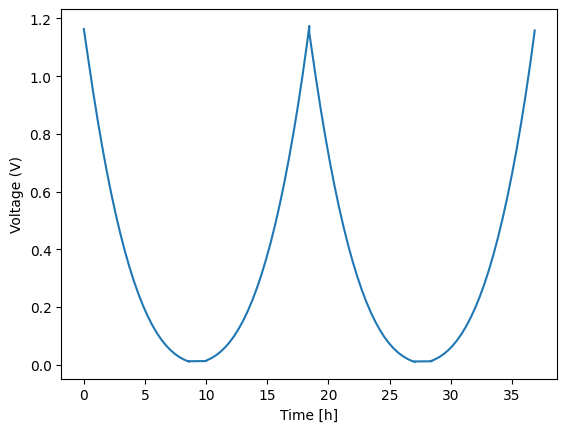

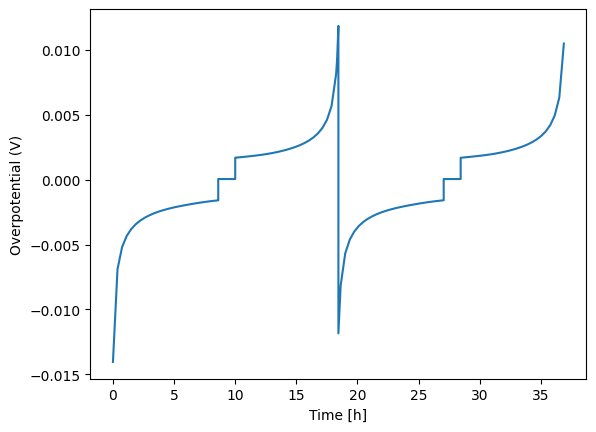

In [298]:
tt = solution.t

# eta_int = solution["Overpotential [V]"].entries
# u0 = solution["Opencircuit voltage [V]"].entries
Jint = solution["intercalation current density [A m-2]"].entries

c = solution["concentration [mol.m-3]"].entries
plt.plot(tt/3600, c)
plt.xlabel('Time [h]')
plt.ylabel('Concentration (mol.m$^{-3}$)')
plt.show()

L = solution["Thickness of SEI [m]"].entries
plt.plot(tt/3600, L)
plt.xlabel('Time [h]')
plt.ylabel('Thickness of SEI (nm)')
plt.show()


vv = solution["Voltage [V]"].entries
plt.plot(tt/3600, vv)
plt.xlabel('Time [h]')
plt.ylabel('Voltage (V)')
plt.show()


eta_int = solution["eta_int"].entries
plt.plot(tt/3600, eta_int)
plt.xlabel('Time [h]')
plt.ylabel('Overpotential (V)')
plt.show()


Q1 = solution["Q1 [A.h]"].entries
# plt.plot(tt, Q1, "o")
# plt.show()

# Capcity = solution["Capcity"].entries
# plt.plot(Q1, vv, "o")
# plt.show()

Q2 = solution["Q2 [A.h]"].entries


# L_app = solution["L_app"].entries
# plt.plot(tt, L_app)
# plt.show()

# # L_diff = solution["L_diff"].entries
# # plt.plot(tt, L_diff)
# # plt.show()

# jtotal = solution["J_total"].entries
# plt.scatter(tt, jtotal)
# plt.show()

# J_int = solution["intercalation current density [A m-2]"].entries
# plt.scatter(tt, J_int*62)
# plt.show()


# kk = solution["kk"].entries
# plt.plot(tt, kk)
# plt.show()

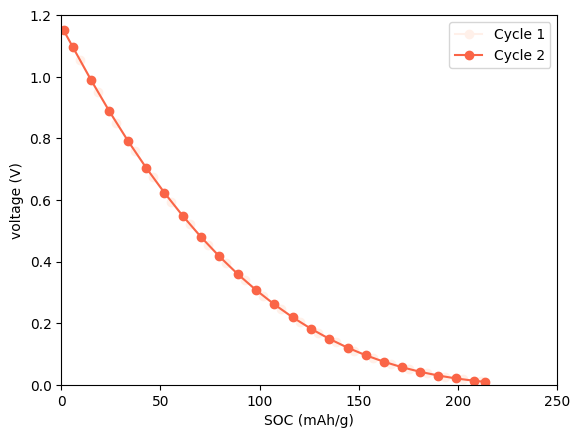

In [301]:
import numpy as np

Q = Q1
v = vv

# Find indices of zeros in Q
zero_indices = np.where(Q == 0)[0]

# Split Q and v based on zero indices
split_Q = np.split(Q, zero_indices + 1)
split_v = np.split(v, zero_indices + 1)

# Remove elements with zeros and corresponding elements in v
filtered_Qi = [subQ[subQ != 0] for subQ in split_Q]
filtered_vi = [subv[subQ != 0] for subv, subQ in zip(split_v, split_Q)]

# Use 'Blues' colormap
cmap = plt.cm.Reds

# Plot each curve with a different color from dark blue to light blue
k = 1
for i, (Qi, vi) in enumerate(zip(filtered_Qi, filtered_vi), 1):
    if len(Qi) > 0:
        # Normalize the color based on the number of curves
        color = cmap(i / len(filtered_Qi))
        plt.plot(Qi, vi, label=f'Cycle {k}', color=color, marker='o')
        k += 1


plt.ylim(0, 1.2)
plt.xlim(0, 250)
plt.xlabel('SOC (mAh/g)')
plt.ylabel('voltage (V)')
plt.legend()